In [70]:
# Defining basic load functions
import cv2
import numpy as np

def load_image(img_filename):
    return cv2.imread(img_filename)

def load_velo_scan(velo_filename, dtype=np.float32, n_vec=4):
    scan = np.fromfile(velo_filename, dtype=dtype)
    scan = scan.reshape((-1, n_vec))
    return scan

def read_label(label_filename):
    lines = [line.rstrip() for line in open(label_filename)]
    objects = [Object3d(line) for line in lines]
    return objects

def read_calib_file(filepath):
    data = {}
    with open(filepath, "r") as f:
        for line in f.readlines():
            line = line.rstrip()
            if len(line) == 0:
                continue
            key, value = line.split(":", 1)
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

def inverse_rigid_trans(Tr):
    """ Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    """
    inv_Tr = np.zeros_like(Tr)  # 3x4
    inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
    inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
    return inv_Tr

In [71]:
class Object3d(object):
    """ 3d object label """

    def __init__(self, label_file_line):
        data = label_file_line.split(" ")
        data[1:] = [float(x) for x in data[1:]]

        # extract label, truncation, occlusion
        self.type = data[0]  # 'Car', 'Pedestrian', ...
        self.truncation = data[1]  # truncated pixel ratio [0..1]
        self.occlusion = int(
            data[2]
        )  # 0=visible, 1=partly occluded, 2=fully occluded, 3=unknown
        self.alpha = data[3]  # object observation angle [-pi..pi]

        # extract 2d bounding box in 0-based coordinates
        self.xmin = data[4]  # left
        self.ymin = data[5]  # top
        self.xmax = data[6]  # right
        self.ymax = data[7]  # bottom
        self.box2d = np.array([self.xmin, self.ymin, self.xmax, self.ymax])

        # extract 3d bounding box information
        self.h = data[8]  # box height
        self.w = data[9]  # box width
        self.l = data[10]  # box length (in meters)
        self.t = (data[11], data[12], data[13])  # location (x,y,z) in camera coord.
        self.ry = data[14]  # yaw angle (around Y-axis in camera coordinates) [-pi..pi]w

In [72]:
class Calibration(object):

    def __init__(self, calib_filepath, from_video=False):
        calibs = self.read_calib_file(calib_filepath)
        # Projection matrix from rect camera coord to image2 coord
        self.P = calibs["P2"]
        self.P = np.reshape(self.P, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = calibs["Tr_velo_to_cam"]
        self.V2C = np.reshape(self.V2C, [3, 4])
        self.C2V = inverse_rigid_trans(self.V2C)
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs["R0_rect"]
        self.R0 = np.reshape(self.R0, [3, 3])

        # Camera intrinsics and extrinsics
        self.c_u = self.P[0, 2]
        self.c_v = self.P[1, 2]
        self.f_u = self.P[0, 0]
        self.f_v = self.P[1, 1]
        self.b_x = self.P[0, 3] / (-self.f_u)  # relative
        self.b_y = self.P[1, 3] / (-self.f_v)

    def read_calib_file(self, filepath):
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass

        return data

    def cart2hom(self, pts_3d):
        """ Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        """
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
        return pts_3d_hom

    # ===========================
    # ------- 3d to 3d ----------
    # ===========================
    def project_velo_to_ref(self, pts_3d_velo):
        pts_3d_velo = self.cart2hom(pts_3d_velo)  # nx4
        return np.dot(pts_3d_velo, np.transpose(self.V2C))

    def project_ref_to_velo(self, pts_3d_ref):
        pts_3d_ref = self.cart2hom(pts_3d_ref)  # nx4
        return np.dot(pts_3d_ref, np.transpose(self.C2V))

    def project_rect_to_ref(self, pts_3d_rect):
        """ Input and Output are nx3 points """
        return np.transpose(np.dot(np.linalg.inv(self.R0), np.transpose(pts_3d_rect)))

    def project_ref_to_rect(self, pts_3d_ref):
        """ Input and Output are nx3 points """
        return np.transpose(np.dot(self.R0, np.transpose(pts_3d_ref)))

    def project_rect_to_velo(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx3 points in velodyne coord.
        """
        pts_3d_ref = self.project_rect_to_ref(pts_3d_rect)
        return self.project_ref_to_velo(pts_3d_ref)

    def project_velo_to_rect(self, pts_3d_velo):
        pts_3d_ref = self.project_velo_to_ref(pts_3d_velo)
        return self.project_ref_to_rect(pts_3d_ref)

    # ===========================
    # ------- 3d to 2d ----------
    # ===========================
    def project_rect_to_image(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(self.P))  # nx3
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:, 0:2]

    def project_velo_to_image(self, pts_3d_velo):
        """ Input: nx3 points in velodyne coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.project_velo_to_rect(pts_3d_velo)
        return self.project_rect_to_image(pts_3d_rect)

    def project_8p_to_4p(self, pts_2d):
        x0 = np.min(pts_2d[:, 0])
        x1 = np.max(pts_2d[:, 0])
        y0 = np.min(pts_2d[:, 1])
        y1 = np.max(pts_2d[:, 1])
        x0 = max(0, x0)
        # x1 = min(x1, proj.image_width)
        y0 = max(0, y0)
        # y1 = min(y1, proj.image_height)
        return np.array([x0, y0, x1, y1])

    # ===========================
    # ------- 2d to 3d ----------
    # ===========================
    def project_image_to_rect(self, uv_depth):
        """ Input: nx3 first two channels are uv, 3rd channel
                   is depth in rect camera coord.
            Output: nx3 points in rect camera coord.
        """
        n = uv_depth.shape[0]
        x = ((uv_depth[:, 0] - self.c_u) * uv_depth[:, 2]) / self.f_u + self.b_x
        y = ((uv_depth[:, 1] - self.c_v) * uv_depth[:, 2]) / self.f_v + self.b_y
        pts_3d_rect = np.zeros((n, 3))
        pts_3d_rect[:, 0] = x
        pts_3d_rect[:, 1] = y
        pts_3d_rect[:, 2] = uv_depth[:, 2]
        return pts_3d_rect

    def project_image_to_velo(self, uv_depth):
        pts_3d_rect = self.project_image_to_rect(uv_depth)
        return self.project_rect_to_velo(pts_3d_rect)

In [73]:
# KITTI point cloud is a (x, y, z, r) point cloud, where (x, y, z) is the 3D coordinates and r is the reflectance value. 
# Each value is in 4-byte float. The raw data is in the form of [x0 y0 z0 r0 x1 y1 z1 r1 ...].
scan = load_velo_scan("/home/user/projects/3d/kitti_visualisation/data/kitti/training/velodyne/000000.bin")
type(scan) 
scan.shape
scan

array([[ 1.8324e+01,  4.9000e-02,  8.2900e-01,  0.0000e+00],
       [ 1.8344e+01,  1.0600e-01,  8.2900e-01,  0.0000e+00],
       [ 5.1299e+01,  5.0500e-01,  1.9440e+00,  0.0000e+00],
       ...,
       [ 3.7180e+00, -1.4060e+00, -1.7370e+00,  3.4000e-01],
       [ 3.7140e+00, -1.3910e+00, -1.7330e+00,  4.1000e-01],
       [ 3.9670e+00, -1.4740e+00, -1.8570e+00,  0.0000e+00]],
      dtype=float32)

In [74]:
# 'label', 'truncated', 'occluded', 'alpha', 'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax', 'dim_height', 'dim_width', 'dim_length', 'loc_x', 'loc_y', 'loc_z', 'rotation_y'
labels = read_label("/home/user/projects/3d/kitti_visualisation/data/kitti/training/label_2/000000.txt")
labels[0].type

'Pedestrian'

In [75]:
# The calibration file contains the values of 6 matrices — P0–3, R0_rect, Tr_velo_to_cam, and Tr_imu_to_velo.
# The Px matrices project a point in the rectified referenced camera coordinate to the camera_x image. 
# camera_0 is the reference camera coordinate. R0_rect is the rectifying rotation for reference coordinate ( rectification makes images of multiple cameras lie on the same plan). 
# Tr_velo_to_cam maps a point in point cloud coordinate to reference co-ordinate.
# Calibration files for synchronizing images and point clouds
calib = Calibration("/home/user/projects/3d/kitti_visualisation/data/kitti/training/calib/000000.txt")
calib.P

array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02,  4.575831e+01],
       [ 0.000000e+00,  7.070493e+02,  1.805066e+02, -3.454157e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  4.981016e-03]])

In [76]:
import os

# Kitti object class for loading data
class kitti_object(object):
    """Load and parse object data into a usable format."""

    def __init__(self, root_dir, split="training", args=None):
        """root_dir contains training and testing folders"""
        self.root_dir = root_dir
        self.split = split
        print(root_dir, split)
        self.split_dir = os.path.join(root_dir, split)

        if split == "training":
            self.num_samples = 7481
        elif split == "testing":
            self.num_samples = 7518
        else:
            print("Unknown split: %s" % (split))
            exit(-1)

        lidar_dir = "velodyne"
        if args is not None:
            lidar_dir = args.lidar
            depth_dir = args.depthdir
            pred_dir = args.preddir

        self.image_dir = os.path.join(self.split_dir, "image_2")
        self.label_dir = os.path.join(self.split_dir, "label_2")
        self.calib_dir = os.path.join(self.split_dir, "calib")
        self.lidar_dir = os.path.join(self.split_dir, lidar_dir)

    def __len__(self):
        return self.num_samples

    def get_image(self, idx):
        assert idx < self.num_samples
        img_filename = os.path.join(self.image_dir, "%06d.png" % (idx))
        return load_image(img_filename)

    def get_lidar(self, idx, dtype=np.float32, n_vec=4):
        assert idx < self.num_samples
        lidar_filename = os.path.join(self.lidar_dir, "%06d.bin" % (idx))
        print(lidar_filename)
        return load_velo_scan(lidar_filename, dtype, n_vec)

    def get_calibration(self, idx):
        assert idx < self.num_samples
        calib_filename = os.path.join(self.calib_dir, "%06d.txt" % (idx))
        return Calibration(calib_filename)

    def get_label_objects(self, idx):
        assert idx < self.num_samples and self.split == "training"
        label_filename = os.path.join(self.label_dir, "%06d.txt" % (idx))
        return read_label(label_filename)

In [77]:
# Load sample kitti dataset
dataset = kitti_object('./data/kitti', 'training')

data_idx = 0
objects = dataset.get_label_objects(data_idx)
pc_velo = dataset.get_lidar(data_idx)
calib = dataset.get_calibration(data_idx)
img = dataset.get_image(data_idx)
img_height, img_width, _ = img.shape

./data/kitti training
./data/kitti/training/velodyne/000000.bin


In [78]:
# Initialize display and import visualization packages
%matplotlib inline
import matplotlib.pyplot as plt
from xvfbwrapper import Xvfb
vdisplay = Xvfb(width=1920, height=1080)
vdisplay.start()
from mayavi import mlab
mlab.init_notebook('ipy') # do not use 'x3d' backend which leads to color missing

Notebook initialized with ipy backend.


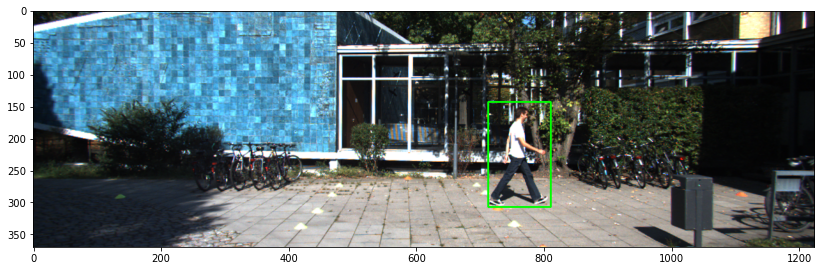

In [79]:
# Show 2d box on image 
img1 = np.copy(img)
img_bbox2d = cv2.rectangle(img1, (int(objects[0].xmin), int(objects[0].ymin)), (int(objects[0].xmax), int(objects[0].ymax)), (0, 255, 0), 2,)
img_bbox2d = cv2.cvtColor(img_bbox2d, cv2.COLOR_BGR2RGB)
fig_bbox2d = plt.figure(figsize=(14, 7))
ax_bbox2d = fig_bbox2d.subplots()
ax_bbox2d.imshow(img_bbox2d)
plt.show()

In [80]:
def roty(t):
    """ Rotation about the y-axis. """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])

In [81]:
obj = objects[0]
def compute_box_3d(object):
    # compute rotational matrix around yaw axis
    R = roty(obj.ry) 

    # 3d bounding box dimensions
    l = obj.l
    w = obj.w
    h = obj.h

    # 3d bounding box corners
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]

    # rotate and translate 3d bounding box
    corners_3d = np.dot(R, np.vstack([x_corners, y_corners, z_corners]))
    # addition with 3D object location x,y,z in camera coordinates
    corners_3d[0, :] = corners_3d[0, :] + obj.t[0]
    corners_3d[1, :] = corners_3d[1, :] + obj.t[1]
    corners_3d[2, :] = corners_3d[2, :] + obj.t[2]
    return(corners_3d)

corners_3d = compute_box_3d(obj)

In [82]:
def project_to_image(pts_3d, P):
    n = pts_3d.shape[0]
    pts_3d_extend = np.hstack((pts_3d, np.ones((n, 1))))
    pts_2d = np.dot(pts_3d_extend, np.transpose(P))  # nx3
    pts_2d[:, 0] /= pts_2d[:, 2]
    pts_2d[:, 1] /= pts_2d[:, 2]
    return pts_2d[:, 0:2]

In [83]:
img_bbox3d = project_to_image(np.transpose(corners_3d), calib.P)
print(img_bbox3d)

[[808.68674867 300.53454034]
 [820.29305993 307.58688203]
 [716.2700834  307.40048192]
 [710.44462716 300.36824124]
 [808.68674867 146.02789809]
 [820.29305993 144.00207322]
 [716.2700834  144.0556177 ]
 [710.44462716 146.07566844]]


In [84]:
def draw_projected_box3d(image, qs, color=(0, 255, 0), thickness=2):
    qs = qs.astype(np.int32)
    for k in range(0, 4):
        i, j = k, (k + 1) % 4
        cv2.line(image, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, thickness)
        i, j = k + 4, (k + 1) % 4 + 4
        cv2.line(image, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, thickness)
        i, j = k, k + 4
        cv2.line(image, (qs[i, 0], qs[i, 1]), (qs[j, 0], qs[j, 1]), color, thickness)
    return image

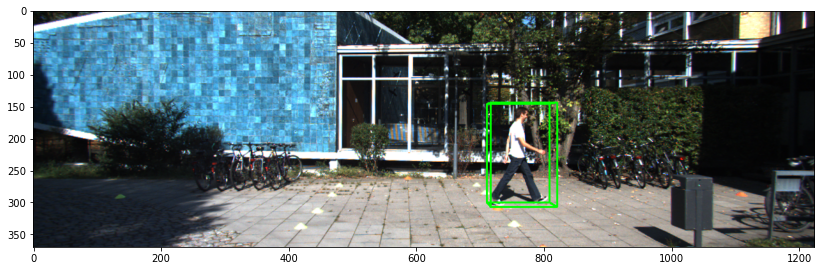

In [85]:
img2 = np.copy(img)
img_bbox3d = draw_projected_box3d(img2, img_bbox3d, color=(0, 255, 0))
img_bbox3d = cv2.cvtColor(img_bbox3d, cv2.COLOR_BGR2RGB)
fig_bbox3d = plt.figure(figsize=(14, 7))
ax_bbox3d = fig_bbox3d.subplots()
ax_bbox3d.imshow(img_bbox3d)
plt.show()

In [86]:
img3 =  np.copy(img)
def get_lidar_in_image_fov(
    pc_velo, calib, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0
):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = calib.project_velo_to_image(pc_velo)
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance)
    imgfov_pc_velo = pc_velo[fov_inds, :]

    return imgfov_pc_velo
    
get_lidar_in_image_fov(pc_velo[:, 0:3], calib, 0, 0, img_width, img_height)

array([[ 1.8324e+01,  4.9000e-02,  8.2900e-01],
       [ 1.8344e+01,  1.0600e-01,  8.2900e-01],
       [ 5.1299e+01,  5.0500e-01,  1.9440e+00],
       ...,
       [ 6.2720e+00, -4.0000e-02, -1.6370e+00],
       [ 6.2740e+00, -3.1000e-02, -1.6370e+00],
       [ 6.2760e+00, -1.1000e-02, -1.6380e+00]], dtype=float32)

In [87]:
imgfov_pts_2d = pts_2d[fov_inds, :]
imgfov_pc_rect = calib.project_velo_to_rect(imgfov_pc_velo[:, 0:3])
cmap = plt.cm.get_cmap("hsv", 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

for i in range(imgfov_pts_2d.shape[0]):
    depth = imgfov_pc_rect[i, 2]
    color = cmap[int(640.0 / depth), :]
    cv2.circle(
        img3,
        (int(np.round(imgfov_pts_2d[i, 0])), int(np.round(imgfov_pts_2d[i, 1]))),
        2,
        color=tuple(color),
        thickness=-1,
    )

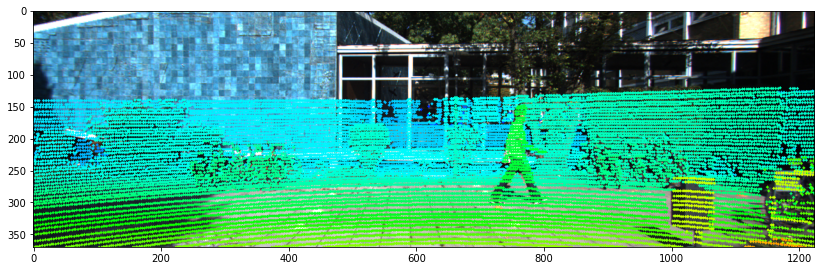

In [88]:
img_lidar = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

fig_lidar = plt.figure(figsize=(14, 7))
ax_lidar = fig_lidar.subplots()
ax_lidar.imshow(img_lidar)
plt.show()

In [89]:
def draw_lidar(
    pc,
    color=None,
    fig=None,
    bgcolor=(0, 0, 0),
    pts_scale=0.3,
    pts_mode="sphere",
    pts_color=None,
    color_by_intensity=False,
    pc_label=False,
):
    """ Draw lidar points
    Args:
        pc: numpy array (n,3) of XYZ
        color: numpy array (n) of intensity or whatever
        fig: mayavi figure handler, if None create new one otherwise will use it
    Returns:
        fig: created or used fig
    """
    # ind = (pc[:,2]< -1.65)
    # pc = pc[ind]
    pts_mode = "point"
    print("====================", pc.shape)
    if fig is None:
        fig = mlab.figure(
            figure=None, bgcolor=bgcolor, fgcolor=None, engine=None, size=(1600, 1000)
        )
    if color is None:
        color = pc[:, 2]
    if pc_label:
        color = pc[:, 4]
    if color_by_intensity:
        color = pc[:, 2]

    mlab.points3d(
        pc[:, 0],
        pc[:, 1],
        pc[:, 2],
        color,
        color=pts_color,
        mode=pts_mode,
        colormap="gnuplot",
        scale_factor=pts_scale,
        figure=fig,
    )

    # draw origin
    mlab.points3d(0, 0, 0, color=(1, 1, 1), mode="sphere", scale_factor=0.2)

    # draw axis
    axes = np.array(
        [[2.0, 0.0, 0.0, 0.0], [0.0, 2.0, 0.0, 0.0], [0.0, 0.0, 2.0, 0.0]],
        dtype=np.float64,
    )
    mlab.plot3d(
        [0, axes[0, 0]],
        [0, axes[0, 1]],
        [0, axes[0, 2]],
        color=(1, 0, 0),
        tube_radius=None,
        figure=fig,
    )
    mlab.plot3d(
        [0, axes[1, 0]],
        [0, axes[1, 1]],
        [0, axes[1, 2]],
        color=(0, 1, 0),
        tube_radius=None,
        figure=fig,
    )
    mlab.plot3d(
        [0, axes[2, 0]],
        [0, axes[2, 1]],
        [0, axes[2, 2]],
        color=(0, 0, 1),
        tube_radius=None,
        figure=fig,
    )

    # draw fov (todo: update to real sensor spec.)
    fov = np.array(
        [[20.0, 20.0, 0.0, 0.0], [20.0, -20.0, 0.0, 0.0]], dtype=np.float64  # 45 degree
    )

    mlab.plot3d(
        [0, fov[0, 0]],
        [0, fov[0, 1]],
        [0, fov[0, 2]],
        color=(1, 1, 1),
        tube_radius=None,
        line_width=1,
        figure=fig,
    )
    mlab.plot3d(
        [0, fov[1, 0]],
        [0, fov[1, 1]],
        [0, fov[1, 2]],
        color=(1, 1, 1),
        tube_radius=None,
        line_width=1,
        figure=fig,
    )

    # draw square region
    TOP_Y_MIN = -20
    TOP_Y_MAX = 20
    TOP_X_MIN = 0
    TOP_X_MAX = 40
    #TOP_Z_MIN = -2.0
    #TOP_Z_MAX = 0.4

    x1 = TOP_X_MIN
    x2 = TOP_X_MAX
    y1 = TOP_Y_MIN
    y2 = TOP_Y_MAX
    mlab.plot3d(
        [x1, x1],
        [y1, y2],
        [0, 0],
        color=(0.5, 0.5, 0.5),
        tube_radius=0.1,
        line_width=1,
        figure=fig,
    )
    mlab.plot3d(
        [x2, x2],
        [y1, y2],
        [0, 0],
        color=(0.5, 0.5, 0.5),
        tube_radius=0.1,
        line_width=1,
        figure=fig,
    )
    mlab.plot3d(
        [x1, x2],
        [y1, y1],
        [0, 0],
        color=(0.5, 0.5, 0.5),
        tube_radius=0.1,
        line_width=1,
        figure=fig,
    )
    mlab.plot3d(
        [x1, x2],
        [y2, y2],
        [0, 0],
        color=(0.5, 0.5, 0.5),
        tube_radius=0.1,
        line_width=1,
        figure=fig,
    )

    # mlab.orientation_axes()
    mlab.view(
        azimuth=180,
        elevation=70,
        focalpoint=[12.0909996, -1.04700089, -2.03249991],
        distance=62.0,
        figure=fig,
    )
    return fig


def draw_gt_boxes3d(
    gt_boxes3d,
    fig,
    color=(1, 1, 1),
    line_width=1,
    draw_text=True,
    text_scale=(1, 1, 1),
    color_list=None,
    label=""
):
    num = len(gt_boxes3d)
    for n in range(num):
        b = gt_boxes3d[n]
        if color_list is not None:
            color = color_list[n]
        if draw_text:
            mlab.text3d(
                b[4, 0],
                b[4, 1],
                b[4, 2],
                label,
                scale=text_scale,
                color=color,
                figure=fig,
            )
        for k in range(0, 4):
            # http://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html
            i, j = k, (k + 1) % 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )

            i, j = k + 4, (k + 1) % 4 + 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )

            i, j = k, k + 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )
    # mlab.show(1)
    # mlab.view(azimuth=180, elevation=70, focalpoint=[ 12.0909996 , -1.04700089, -2.03249991], distance=62.0, figure=fig)
    return fig

In [90]:
def compute_orientation_3d(obj, P):
    """ Takes an object and a projection matrix (P) and projects the 3d
        object orientation vector into the image plane.
        Returns:
            orientation_2d: (2,2) array in left image coord.
            orientation_3d: (2,3) array in in rect camera coord.
    """

    # compute rotational matrix around yaw axis
    R = roty(obj.ry)

    # orientation in object coordinate system
    orientation_3d = np.array([[0.0, obj.l], [0, 0], [0, 0]])

    # rotate and translate in camera coordinate system, project in image
    orientation_3d = np.dot(R, orientation_3d)
    orientation_3d[0, :] = orientation_3d[0, :] + obj.t[0]
    orientation_3d[1, :] = orientation_3d[1, :] + obj.t[1]
    orientation_3d[2, :] = orientation_3d[2, :] + obj.t[2]

    # vector behind image plane?
    if np.any(orientation_3d[2, :] < 0.1):
        orientation_2d = None
        return orientation_2d, np.transpose(orientation_3d)

    # project orientation into the image plane
    orientation_2d = project_to_image(np.transpose(orientation_3d), P)
    return orientation_2d, np.transpose(orientation_3d)

In [93]:
print(("All point num: ", pc_velo.shape[0]))
fig_3d = mlab.figure(bgcolor=(0, 0, 0), size=(800, 450))
fig = mlab.figure(
    figure=None, bgcolor=(0, 0, 0), fgcolor=None, engine=None, size=(1000, 500)
)
pc_velo = get_lidar_in_image_fov(
        pc_velo[:, 0:3], calib, 0, 0, img_width, img_height
    )
print(("FOV point num: ", pc_velo.shape[0]))
print("pc_velo", pc_velo.shape)
draw_lidar(pc_velo, fig=fig)
# pc_velo=pc_velo[:,0:3]

color = (0, 1, 0)
for obj in objects:
    if obj.type == "DontCare":
        continue
    # Draw 3d bounding box
    box3d_pts_3d = compute_box_3d(obj)
    box3d_pts_3d_velo = calib.project_rect_to_velo(np.transpose(box3d_pts_3d))
    print("box3d_pts_3d_velo:")
    print(box3d_pts_3d_velo)

    draw_gt_boxes3d([box3d_pts_3d_velo], fig=fig, color=color)

    # Draw heading arrow
    _, ori3d_pts_3d = compute_orientation_3d(obj, calib.P)
    ori3d_pts_3d_velo = calib.project_rect_to_velo(ori3d_pts_3d)
    x1, y1, z1 = ori3d_pts_3d_velo[0, :]
    x2, y2, z2 = ori3d_pts_3d_velo[1, :]
    mlab.plot3d(
        [x1, x2],
        [y1, y2],
        [z1, z2],
        color=color,
        tube_radius=None,
        line_width=1,
        figure=fig,
    )
    mlab.show(1)
fig_3d

('All point num: ', 20285)
('FOV point num: ', 20285)
pc_velo (20285, 3)
==================== (20285, 3)
box3d_pts_3d_velo:
[[ 8.96440459 -2.45859462 -1.60867186]
 [ 8.48444353 -2.45306157 -1.60607081]
 [ 8.49835837 -1.25324031 -1.59072653]
 [ 8.97831943 -1.25877336 -1.59332758]
 [ 8.97436611 -2.48287864  0.28114573]
 [ 8.49440505 -2.47734559  0.28374677]
 [ 8.50831989 -1.27752433  0.29909105]
 [ 8.98828095 -1.28305738  0.29649   ]]


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x01\xf4\x08\x02\x00\x00\x00!J\x90z\x…